In [1]:
# always run this cell
import os
import sys

print(os.getcwd())
cwd0 = './config/'
sys.path.append(cwd0)

import visualID_Eng as vID
from visualID_Eng import color, fg, hl, bg 
vID.init(cwd0)

/home/romuald/ENSEIGNEMENT/0-JupyterNotebooks/pyPhysChem


**Start at:** Tuesday 23 May 2023, 21:16:55  
**Hostname:** localhost.localdomain (Linux)

<p style="text-align: center"><img width="800px" src="./config/svg/pyPhysChemBanner.svg" style="margin-left:auto; margin-right:auto"/></p>

$$\varepsilon_{i}(\bar{\nu})=\varepsilon_{i}^{\mathrm{max}}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$
It is demonstrated, in a [Gaussian whitepaper](https://gaussian.com/uvvisplot/), that the previous equation becomes, in the cgs units system:
$$\varepsilon_{i}(\bar{\nu})=\frac{\sqrt{\pi}e^{2}N_{\mathrm{A}}}{1000\ln(10)c^{2}m_{e}}\frac{f_{i}}{\sigma}\exp\left[-\left(\frac{\bar{\nu}-\bar{\nu}_{i}}{\sigma}\right)^{2}\right]$$

where:
- $\varepsilon_i$ is the molar absorption coefficient, in units of L∙mol$^{-1}$∙cm$^{-1}$
- $f_i$ is the dimensionless oscillator strength
- $\sigma$, the half-width of the Gaussian band at each $\varepsilon^{\mathrm{max}}$, is in cm$^{-1}$
- $c$ is the speed of light in cm∙s$^{-1}$
- $N_\mathrm{A}$ is the Avogadro number, in mol$^{-1}$
- $m_e$ is the electron mass in g
- $e$ is the elementary charge, in electrostatic unit of charge (esu)

In most cases, there will be more than one electronic excitation in the region of interest. The overall spectrum is obtained from the sum of all the individual bands:

$$\varepsilon(\bar{\nu}) = \sum_{i}^{N}\varepsilon_{i}(\bar{\nu})$$

## Functions

In [2]:
# always run this cell
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc
sigma = 0.3 #eV 0.4 eV is the default value in GaussView
eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
sigmanm = eV2nm/sigma
print(f"sigma = {sigma} eV -> sigmanm = {sigmanm:.1f} nm")

def epsiG(lambdaX,lambdai,fi,sigmanm):
    '''
    calculates a Gaussian band shape around a vertical transition
    input:
        - lambdaX = wavelength variable, in nm
        - lambdai = vertical excitation wavelength for ith state, in nm
        - fi = oscillator strength for state i (dimensionless)
        - sigmanm = half-width of the Gaussian band, in nm
    output :
        molar absorption coefficient, in L mol-1 cm-1
    '''
    import scipy.constants as sc
    import numpy as np
    c = sc.c*1e2 #cm-1
    NA = sc.N_A #mol-1
    me = sc.m_e*1000 #g
    e = sc.e*sc.c*10 #elementary charge in esu 
    pf = np.sqrt(np.pi)*e**2*NA/(1000*np.log(10)*c**2*me)
    nubarX = 1e7 / lambdaX # nm to cm-1
    nubari = 1e7 / lambdai
    sigmabar = 1e7 / sigmanm
    epsi = pf * (fi / sigmabar) * np.exp(-((nubarX - nubari)/sigmabar)**2)
    return epsi

def Absorbance(eps,opl,cc):
    '''
    Calculates the Absorbance with the Beer-Lambert law
    input:
        - eps = molar absorption coefficient, in L mol-1 cm-1
        - opl = optical path length, in cm
        - cc = concentration of the attenuating species, in mol.L-1
    output :
        Absorbance, A (dimensionless)
    '''
    return eps*opl*cc

def sumStatesWithGf(wavel,wavelTAB,feTAB,sigmanm):
    '''
    '''
    import numpy as np
    sumInt = np.zeros(len(wavel))
    for l in wavel:
        for i in range(len(wavelTAB)):
            sumInt[np.argwhere(l==wavel)[0][0]] += epsiG(l,wavelTAB[i],feTAB[i],sigmanm)
    return sumInt

def FindPeaks(sumInt,height,prom=1):
    '''
    '''
    from scipy.signal import find_peaks
    peaks = find_peaks(sumInt, height = height, threshold = None, distance = 1, prominence=prom)
    PeakIndex = peaks[0][:]
    PeakHeight = peaks[1]['peak_heights'][:]
    return PeakIndex,PeakHeight

def pickPeak(wavel,peaksIndex,peaksH,color,shift=0.01,height=0.04,posAnnotation=0.02):
    '''
    '''
    s=shift
    h=height
    a=posAnnotation
    for i in range(len(peaksIndex)):
        x = wavel[peaksIndex[i]]
        y = peaksH[i]
        plt.vlines(x, y+s, y+s+h, colors=color, linestyles='solid')
        plt.annotate(f"{x:.1f}",xy=(x,y),xytext=(x,y+s+h+a),rotation=90,size=12,ha='center',va='bottom')
    return

def plotTDDFTSpectrum(wavel,sumInt,wavelTAB,feTAB,sigmanm,labelSpectrum,xmin=250,xmax=800,save=False,filename='TDDFT.png',colorS='#0000ff',colorT='#0000cf'):
    '''
    '''
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))
    for i in range(len(wavelTAB)):
        plt.vlines(x = wavelTAB[i], ymin = 0, ymax = epsiG(wavelTAB[i],wavelTAB[i],feTAB[i],sigmanm), colors = colorT)
    plt.xlabel('wavelength / nm',size=14,fontweight='bold',color='#2f6b91')
    plt.ylabel('molar absorption coefficient / L mol$^{-1}$ cm$^{-1}$',size=14,fontweight='bold',color='#2f6b91')
    plt.xticks(fontsize=16,fontweight='bold')
    plt.yticks(fontsize=16,fontweight='bold')
    plt.plot(wavel,sumInt,linewidth=3,linestyle='-',color=colorS,label=labelSpectrum)
    plt.xlim(xmin,xmax)
    plt.legend(fontsize=14)
    
    peaks, peaksH = FindPeaks(sumInt,10)
    pickPeak(wavel,peaks,peaksH,colorS,500,500,200)
    # s=500
    # h=500
    # a=200
    # for i in range(len(peaks)):
    #     x = wavel[peaks[i]]
    #     y = peaksH[i]
    #     plt.vlines(x, y+s, y+s+h, colors=colorS, linestyles='solid')
    #     plt.annotate(f"{x:.1f}",xy=(x,y),xytext=(x,y+s+h+a),rotation=90,size=12,ha='center',va='bottom')
    
    import matplotlib.ticker as ticker
    ax = plt.gca() # this is a way to deefined advanced plot options
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50)) # sets a tick for every integer multiple of the base (here 250) within the view interval
    if save:
        plt.savefig(filename,dpi=300,transparent=True)
    plt.show()

def plotEps_lambda_TDDFT(datFile,lambdamin,lambdamax, title="TDDFT plot", tP = 10, sigma=0.3,\
                         save=False,filename='plotEps_lambda.png',colorS='#3e89be',colorVT='#469cd6'):
    '''
    Plots a TDDFT VUV simulated spectrum (vertical transitions and transitions summed with gaussian functions)
    between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
    input:
        - datFile: pathway and name to file generated by 'GParser Gaussian.log -S'
        - lambdamin, lambdamax: plot range
        - title: title of the spectrum plot (default = "TDDFT plot")
        - tP: threshold for finding the peaks (default = 10 L. mol-1 cm-1)
        - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
        - save: saves in a png file (300 dpi) if True (default = False)
        - filename: name of the png file (default = plotEps_lambda.png)
        - colorVT: color of the vertical transition line (default = '#469cd6')
        - colorS: color of the simulated spectrum (default ='#3e89be')
    '''

    import scipy.constants as sc
    sigma = 0.3 #eV 0.4 eV is the default value in GaussView
    eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
    sigmanm = eV2nm/sigma

    istate,state,wavel,fe,SSq = np.genfromtxt(datFile,skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
    wvl = np.arange(lambdamin-50,lambdamax+50,1)
    sumInt = sumStatesWithGf(wvl,wavel,fe,sigmanm)
    plotTDDFTSpectrum(wvl,sumInt,wavel,fe,sigmanm,title,lambdamin,lambdamax,save,filename,colorS,colorVT)
    peaksI, peaksH = FindPeaks(sumInt,tP)
    print(f"{bg.LIGHTREDB}{title}{bg.OFF}")
    for i in range(len(peaksI)):
        print(f"peak {i:3}. {wvl[peaksI[i]]:4} nm. epsilon = {peaksH[i]:.1f} L mol-1 cm-1")
    return

def initializePlotA_lambda(plotW, plotH):
    fig, graph = plt.subplots(figsize=(plotW,plotH))
    plt.subplots_adjust(wspace=0)
    plt.xticks(fontsize=16,fontweight='bold')
    plt.yticks(fontsize=16,fontweight='bold')
    return fig, graph

def plotAbs_lambda_TDDFT(graph, datFiles, C0, lambdamin, lambdamax, Amax, titles, linestyles=[], annotateP=[], tP = 0.1, sigma=0.3, save=False, filename='plotA_lambda.png'):
    '''
    Plots a simulated TDDFT VUV absorbance spectrum (transitions summed with gaussian functions)
    between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
    input:
        - graph: name of the plot object
        - datFiles: list of pathway/name to files generated by 'GParser Gaussian.log -S'
        - C0: list of concentrations needed to calculate A = epsilon x l x c (in mol.L-1)
        - lambdamin, lambdamax: plot range (x axis)
        - Amax: graph limit (y axis)
        - titles: list of titles (1 per spectrum plot)
        - linestyles: list of line styles(default = "--", i.e. a dashed line)
        - annotateP: list of Boolean (annotate lambda max True or False. Default = True)
        - tP: threshold for finding the peaks (default = 0.1)
        - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
        - save: saves in a png file (300 dpi) if True (default = False)
        - filename: name of the png file (default = plotEps_lambda.png)
    '''
    if linestyles == []: linestyles = len(datFiles)*['--']
    if annotateP == []: annotateP = len(datFiles)*[True]
    
    import scipy.constants as sc
    sigma = 0.3 #eV 0.4 eV is the default value in GaussView
    eV2nm = (sc.h * sc.c)*1e9 / (sc.e)
    sigmanm = eV2nm/sigma

    graph.set_xlabel('wavelength / nm',size=14,fontweight='bold',color='#2f6b91')
    graph.set_ylabel('Absorbance',size=14,fontweight='bold',color='#2f6b91')
    graph.set_xlim(lambdamin,lambdamax)
    graph.set_ylim(0,Amax)
    graph.tick_params(axis='both', labelsize=14,labelcolor='black')
    for tick in graph.xaxis.get_majorticklabels(): tick.set_fontweight('bold') #it is both powerful (you can specify the type of a specific tick) and annoying
    for tick in graph.yaxis.get_majorticklabels(): tick.set_fontweight('bold')
    wvl = np.arange(lambdamin-50,lambdamax+50,1)
    for f in range(len(datFiles)):
        istate,state,wavel,fe,SSq = np.genfromtxt(datFiles[f],skip_header=1,dtype="<U20,<U20,float,float,<U20",unpack=True)
        sumInt = sumStatesWithGf(wvl,wavel,fe,sigmanm)
        Abs = Absorbance(sumInt,1,C0[f])
        plot=graph.plot(wvl,Abs,linewidth=3,linestyle=linestyles[f],label=f"{titles[f]}. TDDFT ($C_0$={C0[f]} mol/L)")
        peaksI, peaksH = FindPeaks(Abs,tP,0.01)
        if (annotateP[f]): pickPeak(wvl,peaksI,peaksH,plot[0].get_color(),0.01,0.04,0.02)
        print(f"{bg.LIGHTREDB}TDDFT. {titles[f]}{bg.OFF}")
        for i in range(len(peaksI)):
            print(f"peak {i:3}. {wvl[peaksI[i]]:4} nm. A = {peaksH[i]:.2f}")
    graph.legend(fontsize=14)
    return

def replotAbs_lambda_exp(graph, superpose, csvFiles, C0, lambdamin, lambdamax, Amax, titles, linestyles=[], annotateP=[], tP = 0.1, sigma=0.3, save=False, filename='plotA_lambda.png'):
    '''
    Plots an experimental VUV absorbance spectrum read from a csv file between lambdamin and lambdamax
    input:
        - graph: name of the plot object
        - superpose: False = plots a new graph, otherwise the plot is superposed to a previously created one
                     (probably with plotAbs_lambda_TDDFT())
        - csvfiles: list of pathway/name to experimental csvFiles (see examples for the format)
        - C0: list of experimental concentrations, i.e. for each sample
        - lambdamin, lambdamax: plot range (x axis)
        - Amax: graph limit (y axis)
        - titles: list of titles (1 per spectrum plot)
        - linestyles: list of line styles(default = "-", i.e. a continous line)
        - annotateP: list of Boolean (annotate lambda max True or False. Default = True)
        - tP: threshold for finding the peaks (default = 0.1)
        - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
        - save: saves in a png file (300 dpi) if True (default = False)
        - filename: name of the png file (default = plotEps_lambda.png)
    '''
    if linestyles == []: linestyles = len(csvFiles)*['-']
    if annotateP == []: annotateP = len(csvFiles)*[True]
    
    graph.set_prop_cycle(None)
    
    if not superpose:
        graph.set_xlabel('wavelength / nm',size=14,fontweight='bold',color='#2f6b91')
        graph.set_ylabel('Absorbance',size=14,fontweight='bold',color='#2f6b91')
        graph.set_xlim(lambdamin,lambdamax)
        graph.set_ylim(0,Amax)
        graph.tick_params(axis='both', labelsize=14,labelcolor='black')
        for tick in graph.xaxis.get_majorticklabels(): tick.set_fontweight('bold') #it is both powerful (you can specify the type of a specific tick) and annoying
        for tick in graph.yaxis.get_majorticklabels(): tick.set_fontweight('bold')
    for f in range(len(csvFiles)):
        wavel,Abs = np.genfromtxt(csvFiles[f],skip_header=1,unpack=True,delimiter=";")
        wavel *= 1e9
        plot=graph.plot(wavel,Abs,linewidth=3,linestyle=linestyles[f],label=f"{titles[f]}. exp ($C_0$={C0[f]} mol/L)")
        peaksI, peaksH = FindPeaks(Abs,tP,0.01)
        if (annotateP[f]): pickPeak(wavel,peaksI,peaksH,plot[0].get_color(),0.01,0.04,0.02)
        print(f"{bg.LIGHTREDB}exp. {titles[f]}{bg.OFF}")
        for i in range(len(peaksI)):
            print(f"peak {i:3}. {wavel[peaksI[i]]:4} nm. A = {peaksH[i]:.2f}")
    graph.legend(fontsize=14)

    return

sigma = 0.3 eV -> sigmanm = 4132.8 nm


## Documentation 

In [3]:
?plotEps_lambda_TDDFT

Signature:
plotEps_lambda_TDDFT(
    datFile,
    lambdamin,
    lambdamax,
    title='TDDFT plot',
    tP=10,
    sigma=0.3,
    save=False,
    filename='plotEps_lambda.png',
    colorS='#3e89be',
    colorVT='#469cd6',
)
Docstring:
Plots a TDDFT VUV simulated spectrum (vertical transitions and transitions summed with gaussian functions)
between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
input:
    - datFile: pathway and name to file generated by 'GParser Gaussian.log -S'
    - lambdamin, lambdamax: plot range
    - title: title of the spectrum plot (default = "TDDFT plot")
    - tP: threshold for finding the peaks (default = 10 L. mol-1 cm-1)
    - sigma: half-width of gaussian functions, in eV (default = 0.3 eV)
    - save: saves in a png file (300 dpi) if True (default = False)
    - filename: name of the png file (default = plotEps_lambda.png)
    - colorVT: color of the vertical transition line (default = '#469cd6')
    - colorS: c

In [4]:
?plotAbs_lambda_TDDFT

Signature:
plotAbs_lambda_TDDFT(
    graph,
    datFiles,
    C0,
    lambdamin,
    lambdamax,
    Amax,
    titles,
    linestyles=[],
    annotateP=[],
    tP=0.1,
    sigma=0.3,
    save=False,
    filename='plotA_lambda.png',
)
Docstring:
Plots a simulated TDDFT VUV absorbance spectrum (transitions summed with gaussian functions)
between lambdamin and lambdamax (sum of states done in the range [lambdamin-50, lambdamlax+50] nm)
input:
    - graph: name of the plot object
    - datFiles: list of pathway/name to files generated by 'GParser Gaussian.log -S'
    - C0: list of concentrations needed to calculate A = epsilon x l x c (in mol.L-1)
    - lambdamin, lambdamax: plot range (x axis)
    - Amax: graph limit (y axis)
    - titles: list of titles (1 per spectrum plot)
    - linestyles: list of line styles(default = "--", i.e. a dashed line)
    - annotateP: list of Boolean (annotate lambda max True or False. Default = True)
    - tP: threshold for finding the peaks (default = 0.1)


In [5]:
?replotAbs_lambda_exp

Signature:
replotAbs_lambda_exp(
    graph,
    superpose,
    csvFiles,
    C0,
    lambdamin,
    lambdamax,
    Amax,
    titles,
    linestyles=[],
    annotateP=[],
    tP=0.1,
    sigma=0.3,
    save=False,
    filename='plotA_lambda.png',
)
Docstring:
Plots an experimental VUV absorbance spectrum read from a csv file between lambdamin and lambdamax
input:
    - graph: name of the plot object
    - superpose: False = plots a new graph, otherwise the plot is superposed to a previously created one
                 (probably with plotAbs_lambda_TDDFT())
    - csvfiles: list of pathway/name to experimental csvFiles (see examples for the format)
    - C0: list of experimental concentrations, i.e. for each sample
    - lambdamin, lambdamax: plot range (x axis)
    - Amax: graph limit (y axis)
    - titles: list of titles (1 per spectrum plot)
    - linestyles: list of line styles(default = "-", i.e. a continous line)
    - annotateP: list of Boolean (annotate lambda max True or False. 

## Examples
### Plot of epsilon = f($\lambda$)

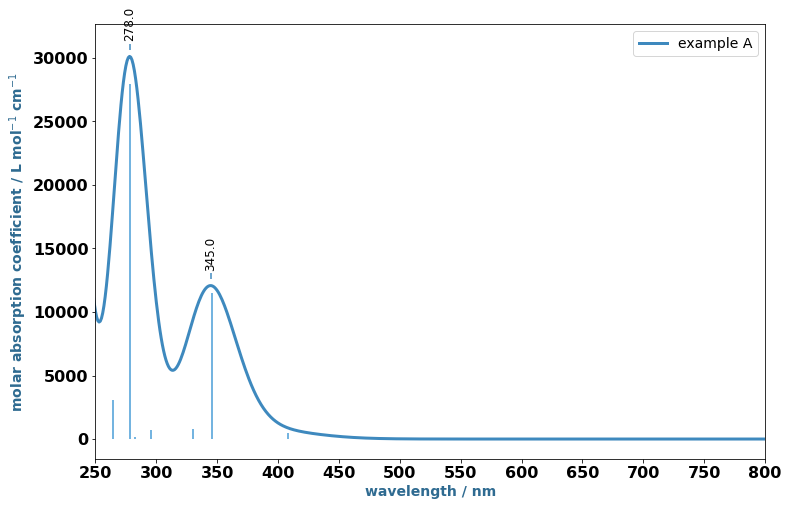

example A
peak   0.  231 nm. epsilon = 29301.0 L mol-1 cm-1
peak   1.  278 nm. epsilon = 30119.0 L mol-1 cm-1
peak   2.  345 nm. epsilon = 12077.1 L mol-1 cm-1


In [6]:
plotEps_lambda_TDDFT("./EasterEgg/test-tabA.dat",250,800,"example A", 10, 0.3, False)

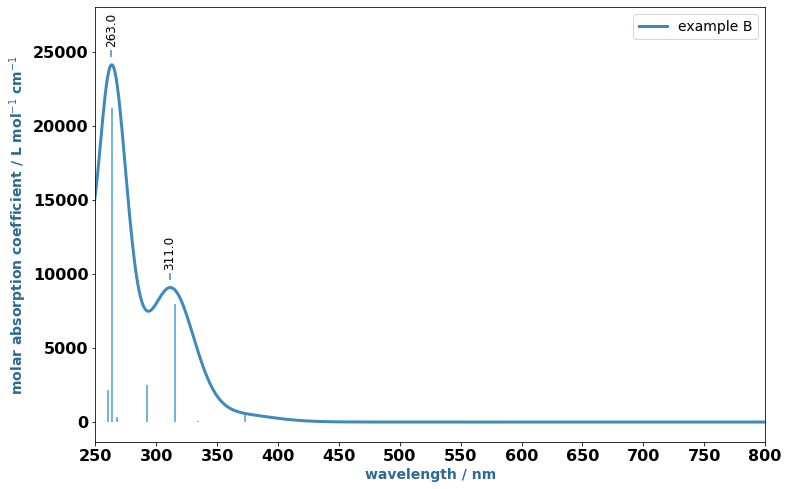

example B
peak   0.  228 nm. epsilon = 25724.3 L mol-1 cm-1
peak   1.  263 nm. epsilon = 24147.6 L mol-1 cm-1
peak   2.  311 nm. epsilon = 9091.4 L mol-1 cm-1


In [7]:
plotEps_lambda_TDDFT("./EasterEgg/test-tabB.dat",250,800,"example B",10,0.3,False)

### Plot of A = f($\lambda$)

TDDFT. test A
peak   0.  345 nm. A = 1.09
TDDFT. test B
peak   0.  311 nm. A = 0.82
exp. after irradiation [acetone]
peak   0. 362.0 nm. A = 0.84
peak   1. 558.0 nm. A = 1.46
exp. after irradiation [ethanol]
peak   0. 350.0 nm. A = 0.20
peak   1. 536.0 nm. A = 0.23


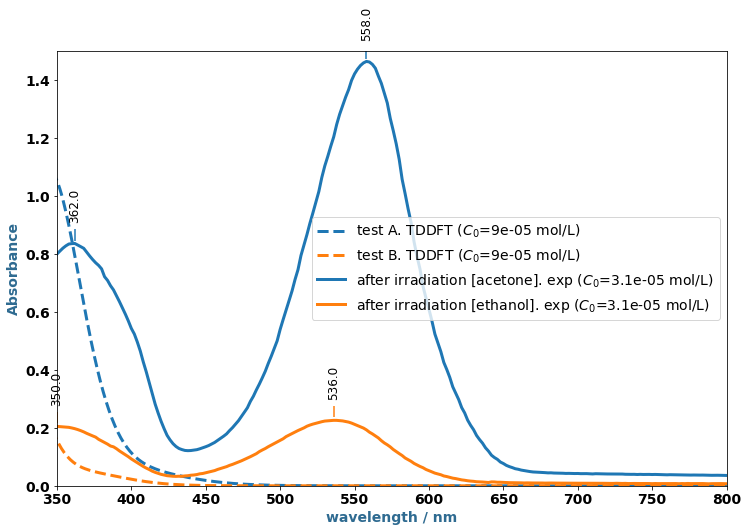

In [8]:
#### Both for TDDFT and exp spectra
fig, graph = initializePlotA_lambda(12, 8)
lambdaMin = 350
lambdaMax = 800
Amax = 1.5

#### TDDFT
datFilesTDDFT = ["./EasterEgg/test-tabA.dat","./EasterEgg/test-tabB.dat"]
C0theo = [9e-5]*2
titlesTDDFT = ["test A", "test B"]
plotAbs_lambda_TDDFT(graph, datFilesTDDFT, C0theo, lambdaMin, lambdaMax, Amax, titlesTDDFT)

#### exp
csvFilesExp = ["./EasterEgg/ExpAbsSpectrumAc.csv","./EasterEgg/ExpAbsSpectrumEtOH.csv"]
C0exp = [3.1e-5]*2
titlesExp = ["after irradiation [acetone]", "after irradiation [ethanol]"]
replotAbs_lambda_exp(graph, True, csvFilesExp, C0exp, lambdaMin, lambdaMax, Amax, titlesExp)

## Try it for yourself!

In [9]:
# insert your code here...

In [10]:
vID.end(cwd0)

**End at:** Tuesday 23 May 2023, 21:17:02  
**Duration:** 00:00:07 019ms

<p style="text-align: center"><img width="800px" src="./config/svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"/></p>